# Energy mix analysis

In the results from the baseline scenario we can notice that the gas power plant is not in use, and that wind generation decreases untill year 710 when it goes out of service because of its 20 years lifetime. 

At that point, it is more economical to exploit coal plant only rather than building a new wind plant: all investment costs are avoided by the cost minimization algorithm.

For the same reason, the construction of gas plant is not even planned in year 690.
The price of electricity decreases because of the increasing share of coal generation.

## Proposed adjustments

Add a sensitivity analysis starting the baseline scenario in year 690 with 
- 40% share of coal and 20% gas generation (``westeros_bis_energymix1.ipynb``)
- 20% share of coal and 40% gas generation (``westeros_bis_energymix2.ipynb``)

and compare the results.

### Pre-requisites
- You have the MESSAGEix framework installed and working
- You have run Westeros baseline scenario (``westeros_bis_baseline.ipynb``) and solved it successfully

Importing the baseline scenario

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

In [3]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen_em2 = base.clone(model, 'energy mix','exploring the share of fossil generation',
                  keep_solution=False)
scen_em2.check_out()

In [4]:
year_df = scen_em2.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen_em2.set('year') 
country = 'Westeros'

## Editing the energy mix at year 690

Re-introducing parameters for computation of base state.

In [5]:
history = [690]
demand_per_year = 40 * 12 * 1000 / 8760
grid_efficiency = 0.9

historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency

# key parameters!
coal_fraction = 0.2
ngcc_fraction = 0.4

Re-introducing capacity factor, base capacity and base activity

In [6]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [7]:
capacity_factor = { # power plants cf as indicated in the reference https://doi.org/10.1016/B978-0-12-810448-4.00001-X
    'coal_ppl': 0.85, # used to be 1 in the absence of other fossil generation, now it is lower than one
    'wind_ppl': 0.36, 
    'ngcc_ppl': 0.87, 
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen_em2.add_par('capacity_factor', df)

In [8]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [9]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'ngcc_ppl': ngcc_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction - ngcc_fraction) * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen_em2.add_par('historical_activity', df)

In [10]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 3.5, # 35 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'ngcc_ppl': 1 / 10 / capacity_factor['ngcc_ppl'] / 2.5, # 25 year lifetime
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen_em2.add_par('historical_new_capacity', df)

Solving the model

In [11]:
scen_em2.commit(comment='introducing emissions and setting an upper bound')
scen_em2.set_as_default()

In [12]:
scen_em2.solve()

In [13]:
scen_em2.var('OBJ')['lvl']

372333.71875

Plotting the results

In [14]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_em2)
prepare_plots(rep)

Activity

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

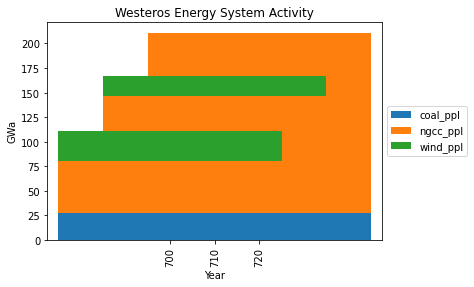

In [15]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "ngcc_ppl"])
rep.get("plot activity")

Capacity

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

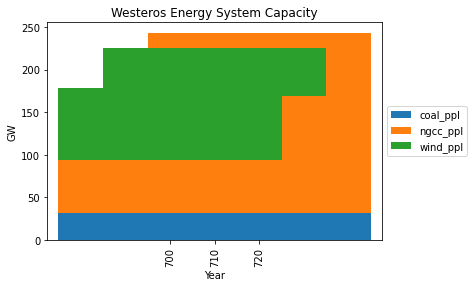

In [16]:
rep.get("plot capacity")

Electricity price

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

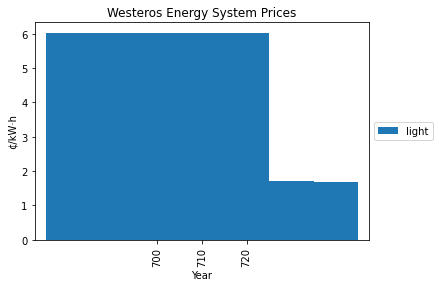

In [17]:
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

# Comments on the results

- total cost is reduced from 466358.3125 (only coal) to 372333.7188 (20.2%)
- Coal technology is constant in the whole horizon.
- Gas technology is present, increasing, and replacing all the wind share in the last decade since it is a cheaper technology.
- Price is drastically reduced after first decade!

Close the connection to the database

In [18]:
mp.close_db()